In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
import os
import pandas as pd
import numpy as np
import cv2

In [11]:
base_dir = r'E:\AB\pneumonia_binary\train'
img_h,img_w= (224,224)
batch_size=256
epochs=3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen= ImageDataGenerator(horizontal_flip=True, vertical_flip=True,width_shift_range=0.2, height_shift_range=0.2,zoom_range=0.2,brightness_range=[0.2,1.2],rescale=1./255,validation_split=0.2)

In [12]:
import keras
#from keras.applications.mobilenet import MobileNet
from keras.applications.nasnet import NASNetMobile
from keras.models import Model,load_model,Sequential
from keras.layers import Input,Activation, Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import EarlyStopping, History
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

import keras
from tensorflow.python.keras.metrics import Metric

base_model = NASNetMobile(input_shape=(img_h,img_w,3), include_top=False,weights='imagenet')

for layer in base_model.layers[:-7]:
    layer.trainable=False

 
model=Sequential()
model.add(base_model)
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))


model.add(Dense(2,activation='sigmoid'))
#model.add(Dense(1))
#model.add(Activation("sigmoid"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 1056)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 1056)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 9504)              0         
                                                                 
 dropout_3 (Dropout)         (None, 9504)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 19010     
                                                      

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=3,
                                         cooldown=2,
                                         min_lr=1e-10,
                                         verbose=1)

checkpoint =tf.keras.callbacks.ModelCheckpoint(filepath="nasnetmobile.h5", 
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True, 
                            save_weights_only=False, 
                            mode='auto',
                            save_freq='epoch')


import time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

callbacks = [reduce_learning_rate, checkpoint, time_callback]
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile( loss='binary_crossentropy',optimizer= optimizer, metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall()])

In [27]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [34]:
import splitfolders # or import splitfolders
input_folder = "E:\\AB\\pneumonia_binary\\train"
output = "E:\\AB\\pneumonia_binary\\split" #

splitfolders.ratio(input_folder, output=output, seed=1337, ratio=(.7, .3)) # 
.

Copying files: 4192 files [00:30, 135.27 files/s]


In [35]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(train_generator, #test,
 #   test_size=0.2, shuffle = True, random_state = 8)
#x,y = train_test_split(base_dir)
#X_train, X_val, y_train, y_val = train_test_split(train_generator,# validation_generator, 
 #   test_size=0.25, random_state= 8)


In [14]:
val_dir = r'E:\AB\pneumonia_binary\split\val'
base_dir = r'E:\AB\pneumonia_binary\split\train'
train_generator = datagen.flow_from_directory(
        base_dir,  # This is the source directory for training images
        target_size=(img_h,img_w),  
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
      #  color_mode="grayscale",
        shuffle=True)


validation_generator = datagen.flow_from_directory(
        val_dir,     
        target_size=(img_h, img_w),
        batch_size=batch_size,
        class_mode='categorical',
      #  color_mode="grayscale",
        subset='validation',
        shuffle=False)

Found 2515 images belonging to 2 classes.
Found 251 images belonging to 2 classes.


In [15]:
history = model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples//batch_size, 
      epochs=5,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//batch_size,  
      callbacks=callbacks,
      verbose=1)

Epoch 1/5
9/9 [==============================] - 286s 31s/step - loss: 2.7832 - accuracy: 0.6950 - precision_1: 0.6699 - recall_1: 0.6990 - lr: 0.0010
Epoch 2/5
9/9 [==============================] - 217s 24s/step - loss: 1.0127 - accuracy: 0.7795 - precision_1: 0.7598 - recall_1: 0.7632 - lr: 0.0010
Epoch 3/5
9/9 [==============================] - 178s 20s/step - loss: 1.0623 - accuracy: 0.7773 - precision_1: 0.7627 - recall_1: 0.7711 - lr: 0.0010
Epoch 4/5
9/9 [==============================] - 131s 14s/step - loss: 0.7831 - accuracy: 0.8198 - precision_1: 0.8106 - recall_1: 0.8070 - lr: 0.0010
Epoch 5/5
9/9 [==============================] - 125s 14s/step - loss: 0.8365 - accuracy: 0.8168 - precision_1: 0.8071 - recall_1: 0.8025 - lr: 0.0010


In [16]:
model.evaluate(validation_generator,verbose=1)

1/1 [==============================] - 56s 56s/step - loss: 0.6901 - accuracy: 0.8406 - precision_1: 0.7978 - recall_1: 0.8805


[0.6901435256004333,
 0.8406374454498291,
 0.7978339195251465,
 0.8804780840873718]

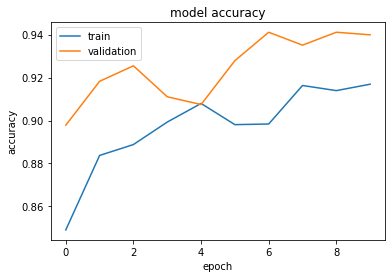

In [41]:
from matplotlib import pyplot as plt 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [85]:
accu= history.history['val_accuracy']
print(max(accu),"at epoch number-",accu.index(max(accu))+1)

0.925000011920929 at epoch number- 2


In [17]:
img = cv2.imread("E:\\AB\\pneumonia_binary\\test\\opacity\\person17_virus_48.jpeg") 
image_resized= cv2.resize(img, (img_h,img_w))
'''cv2.imshow('CT scan', img)
cv2.waitKey(0)
'''
img=np.expand_dims(image_resized,axis=0)
np.set_printoptions(suppress=True)
pred=model.predict(img)
#print(pred);
yn=np.argmax(pred,axis=1)
if yn==0:
    print("Pneumonia")
else :
    print("Not")

Not


In [18]:
img2 = cv2.imread("E:\\AB\\pneumonia_binary\\val\\normal\\NORMAL2-IM-1102-0001-0002.jpeg") 
image_resized= cv2.resize(img2, (img_h,img_w))
pred=model.predict(img)
pred


array([[0., 1.]], dtype=float32)

In [13]:
model2= tf.keras.models.load_model("nasnetmobile.h5")
y_pred= model2.predict(validation_generator,verbose=1)
y_true= validation_generator.classes
y_pred2= np.argmax(y_pred,axis=1)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_true,y_pred2))
from sklearn.metrics import confusion_matrix

cf=confusion_matrix(y_true, y_pred2)

26/26 [==============================] - 13s 385ms/step
0.9178743961352657


In [14]:
cf

array([[ 46,   7],
       [ 10, 144]], dtype=int64)